# AMI JWST Phase Retrieval on Simulated Data
In this notebook we will generate some fake AMI data and fit to it. The free parameters used in this model will be:
- Source Flux
- $7 \times 6$ Hexike coefficients
- 7 or so 2ndary mirror aberrations [not implemented error]

Importing relevant packages

In [23]:
import webbpsf
import dLux as dl
import dLuxWebbpsf as dlW

import jax.numpy as np
import jax.random as jr

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import optax
import zodiax as zdx
import jax

from dLux.utils import deg_to_rad as d2r
import dLux.utils as dlu
from detector_layers import DistortionFromSiaf

plt.rcParams['image.origin'] = 'lower'

## Building NIRISS model

In [24]:
# Primary mirror - note this class automatically flips about the y-axis
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.calc_psf()  # calculating fits files
webbpsfobj.pupil_mask = "MASK_NRM"
NIS_CEN_aperture = webbpsfobj.siaf.apertures["NIS_CEN"]
webbpsf_osys = webbpsfobj.get_optical_system()
planes = webbpsf_osys.planes

In [25]:
radial_orders = np.array([0, 1, 2], dtype=int)
secondary_radial_orders = np.array([2, 3], dtype=int)
hexike_shape = (7, int(np.sum(np.array([dl.utils.triangular_number(i+1) - dl.utils.triangular_number(i) for i in radial_orders]))))
secondary_shape = (int(np.sum(np.array([dl.utils.triangular_number(i+1) - dl.utils.triangular_number(i) for i in secondary_radial_orders]))),)

true_flux = 1e8
true_primary_coeffs = 1e-7 * jr.normal(jr.PRNGKey(0), hexike_shape)
true_secondary_coeffs = 1e-7 * jr.normal(jr.PRNGKey(0), secondary_shape)

true_coeffs_dict = {'primary': true_primary_coeffs, 'secondary': true_secondary_coeffs}

In [26]:
planes

In [39]:
npix = 1024
oversample = 4
pscale = (planes[-1].pixelscale).to("arcsec/pix").value
pupil_plane = planes[-2]

osys = dl.LayeredOptics(
    wf_npixels=1024,
    diameter=planes[0].pixelscale.to("m/pix").value * planes[0].npix,
    layers=[
        (dlW.optical_layers.JWSTAberratedPrimary(
            planes[0].amplitude,
            planes[0].opd,
            radial_orders=radial_orders,
            coefficients=true_primary_coeffs,
            secondary_radial_orders=secondary_radial_orders,
            secondary_coefficients=true_secondary_coeffs,
            AMI=True,
        ), "Pupil"),
        #(dl.Flip((0, 1)), "InvertXY"),
        (dl.Flip(0), "InvertY"),
        # (dl.Optic(planes[2].amplitude, planes[2].opd), "PriorOPD"),
        (dl.Optic(pupil_plane.amplitude), "Mask"),
        (dlW.MFT(npixels=oversample * 64, oversample=oversample, pixel_scale=pscale), "Propagator"),
    ]
)

src = dl.PointSource(flux=true_flux, **dict(np.load("filter_configs/F480M.npz")))
detector = dl.LayeredDetector(
    [
        dlW.detector_layers.Rotate(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),
        DistortionFromSiaf(
            aperture=NIS_CEN_aperture
        ),  # TODO implement dLuxWebbpsf version
        dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    ]
)

instrument = dl.Instrument(sources=[src], detector=detector, optics=osys)

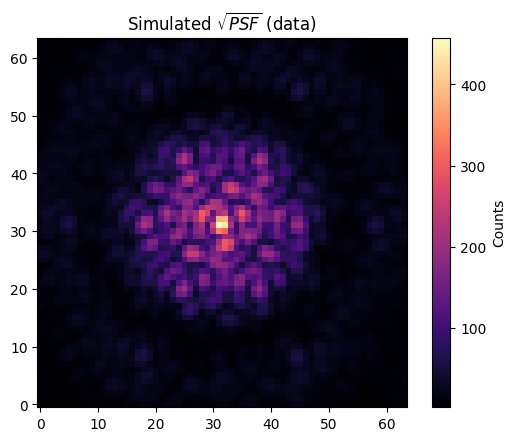

In [27]:
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# 
# # plt.imshow(np.flipud(planes[3].amplitude))
# plt.imshow(planes[3].amplitude)
# plt.colorbar()
# 
# plt.subplot(1, 2, 2)
# plt.imshow(instrument.Pupil.basis_opd)
# plt.colorbar()
# plt.show()

In [28]:
# instrument = instrument.multiply(['Pupil.coefficients.primary', 'Pupil.coefficients.secondary', 'Pupil.opd'], 0)

# Simulating fake data
Here we are using a "true" flux value of $10^6$ photons, and all the "true" coefficient values are randomly generated.

In [29]:
data = jr.poisson(jr.PRNGKey(0), instrument.model())
# data = instrument.model()

plt.imshow(data**0.5, cmap='magma')
# plt.imshow(data, cmap='magma')
plt.title('Simulated $\sqrt{PSF}$ (data)')
plt.colorbar(label='Counts')
plt.show()

## Optimisation
Let's define our paths to our parameters inside of the instrument object.

In [30]:
flux_path = 'PointSource.flux'
coeffs_path = 'optics.Pupil.coefficients'

parameter_paths = [flux_path, coeffs_path]

Defining our model to be a copy of the instrument object, with random initial value of flux and all coefficients starting at zero.

In [31]:
# Multiply the fluxes by small random values
model = instrument.multiply(flux_path, 1 + 0.1*jr.normal(jr.PRNGKey(0)))

# Set the zernike coefficients to zero
model = model.set(coeffs_path, {'primary': np.zeros(hexike_shape), 'secondary': np.zeros(secondary_shape)})

Creating our optimisers using optax - the `adam` algorithm is a gradient descent algorithm with momentum and acceleration terms to avoid falling trap to local minima.

In [32]:
# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
flux_optimiser  = optax.adam(1e5, b1=0.85)
coeff_optimiser = optax.adam(2e-8)

# Combine the optimisers into a list
optimisers = [flux_optimiser, coeff_optimiser]

# Generate out optax optimiser, and also get our args
optim, opt_state = zdx.get_optimiser(model, parameter_paths, optimisers)

Initial Loss: 1652017
CPU times: user 4.6 s, sys: 441 ms, total: 5.04 s
Wall time: 2.5 s


Defining our loss function and jitting it - this will make the function evaluation much faster in subsequent calls.

In [33]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameter_paths)
def loss_fn(model, data):
    out = model.model()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Checking the loss at our initial values.

In [34]:
%%time
loss, grads = loss_fn(model, data) # Compile
print("Initial Loss: {}".format(int(loss)))

Running gradient descent!

In [109]:
losses, models_out = [], []
iters = 200
with tqdm(range(iters),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, data)    
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Grabbing the output.

In [110]:
psfs_out = models_out[-1].model()

flux_found = np.array([model.get(flux_path) for model in models_out])
primary_coeffs_found = np.array([model.get(coeffs_path)['primary'] for model in models_out])
secondary_coeffs_found = np.array([model.get(coeffs_path)['secondary'] for model in models_out])

In [37]:
primary_residuals = true_coeffs_dict['primary'] - primary_coeffs_found
secondary_residuals = true_coeffs_dict['secondary'] - secondary_coeffs_found
flux_residuals = true_flux - flux_found

Plotting loss and residuals.

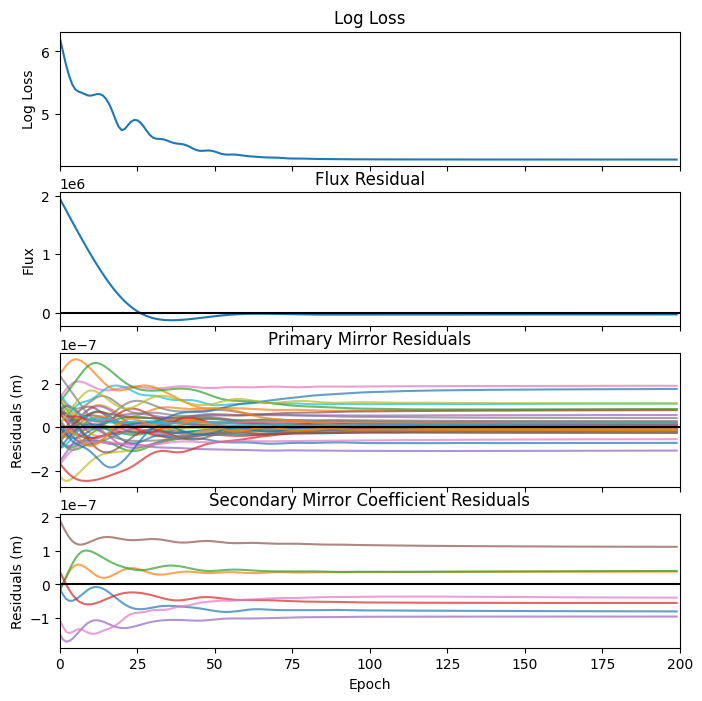

In [112]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

ax[0].plot(np.log10(np.array(losses)))
ax[0].set(title='Log Loss', ylabel='Log Loss', xlim=(0, iters))

ax[1].plot(flux_residuals)
ax[1].set(title='Flux Residual', ylabel='Flux')
ax[1].axhline(0, color='k')

ax[2].plot(primary_residuals.reshape((primary_residuals.shape[0], primary_residuals.shape[1]*primary_residuals.shape[2])), alpha=0.7)
ax[2].set(title='Primary Mirror Residuals', ylabel='Residuals (m)')
ax[2].axhline(0, color='k')

ax[3].plot(secondary_residuals, alpha=0.7)
ax[3].set(title='Secondary Mirror Coefficient Residuals', xlabel='Epoch', ylabel='Residuals (m)')
ax[3].axhline(0, color='k')

plt.show()

Checking out the OPD!

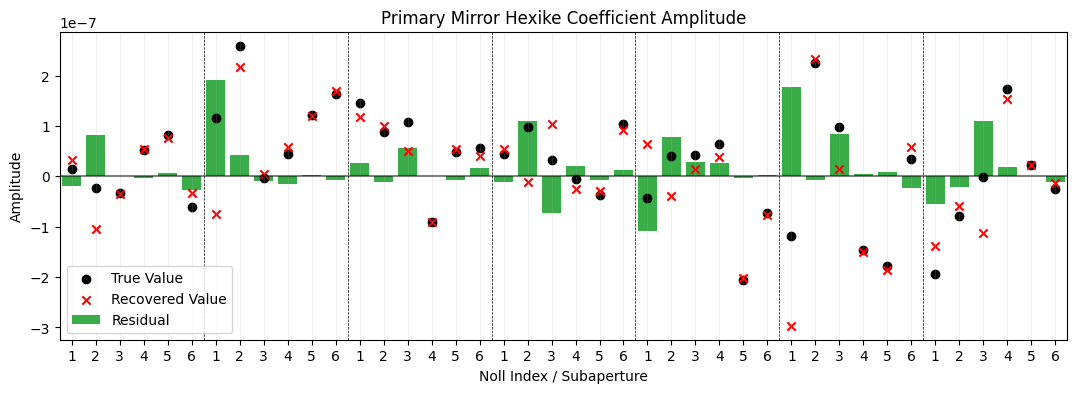

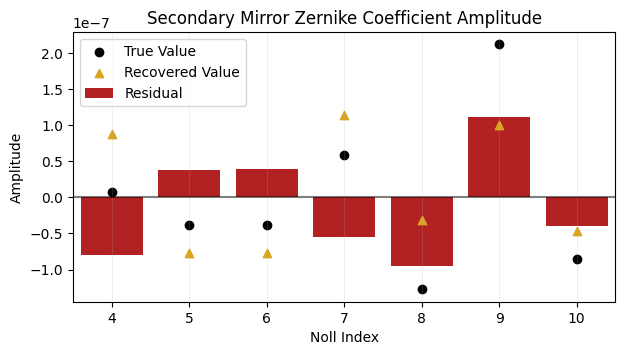

In [40]:
pupil_support = np.flip(instrument.Mask.transmission, (0,1))
support_mask = np.where(pupil_support > 0.5)

true_opd = instrument.Pupil.basis_opd
opds_found = np.array([model.Pupil.basis_opd[support_mask] for model in models_out])
opd_found = models_out[-1].Pupil.basis_opd
opd_residuals = true_opd[support_mask] - opds_found

opd_rmse_nm = 1e9*np.mean(opd_residuals**2, axis=(-1))**0.5

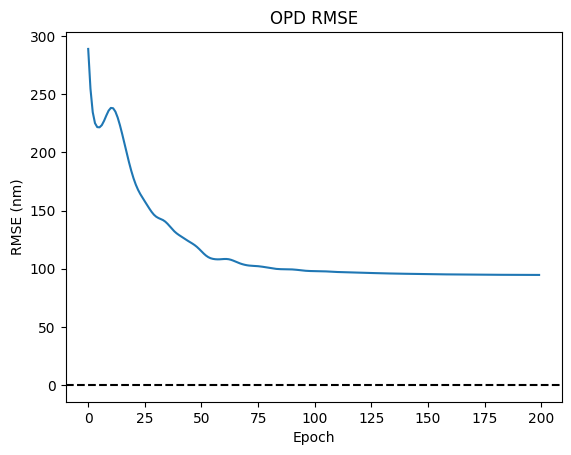

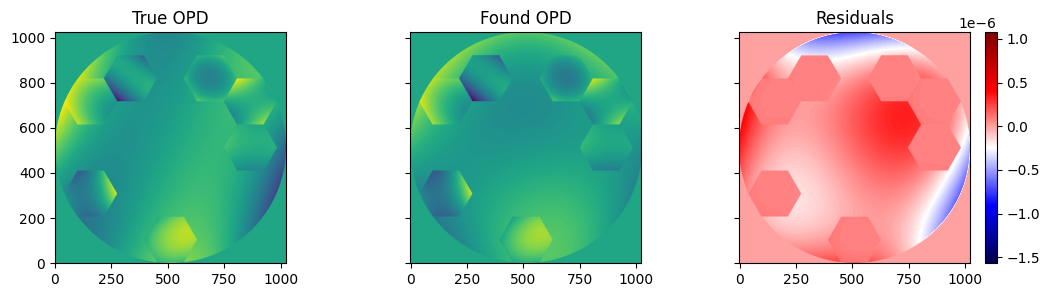

In [114]:
vmin = np.min(np.array([true_opd, opd_found]))
vmax = np.max(np.array([true_opd, opd_found]))

fig, ax = plt.subplots()
ax.plot(opd_rmse_nm)
ax.set(title='OPD RMSE', xlabel='Epoch', ylabel='RMSE (nm)')
ax.axhline(0, color='k', linestyle='--')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(13,3), sharey=True)
ax[0].imshow(true_opd, vmin=vmin, vmax=vmax)
ax[0].set(title='True OPD')

ax[1].imshow(opd_found, vmin=vmin, vmax=vmax)
ax[1].set(title='Found OPD')

c = ax[2].imshow(true_opd - opd_found, vmin=vmin, vmax=vmax, cmap='seismic')
ax[2].set(title='Residuals')
fig.colorbar(c)
plt.show()

Visualising the accuracy of the coefficients (love this plot, thanks Louis)

In [115]:
def radial_to_noll(radial_orders):
    noll_indices = []
    for order in radial_orders:
        start = dlu.triangular_number(order)
        stop = dlu.triangular_number(order + 1)
        noll_indices.append(np.arange(start, stop) + 1)
    return np.concatenate(noll_indices, dtype=int)  
    
# Primary
flat_true_primary_coeffs = instrument.get(coeffs_path)['primary'].flatten()
flat_found_primary_coeffs = primary_coeffs_found[-1].flatten()
index = np.arange(len(flat_true_primary_coeffs))

# Secondary
secondary_index = np.arange(len(true_secondary_coeffs))

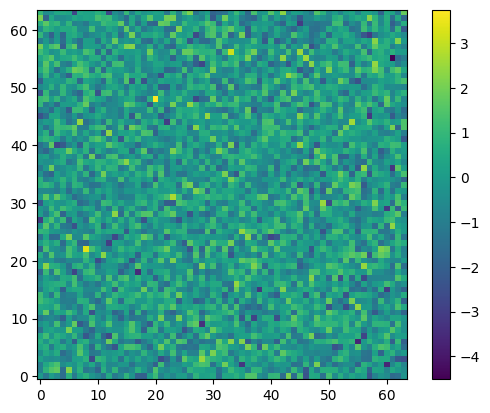

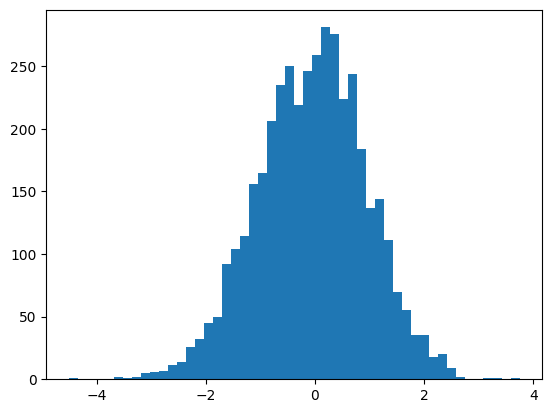

In [42]:
# Plotting Primary
plt.figure(figsize=(13, 4))
plt.title("Primary Mirror Hexike Coefficient Amplitude")
plt.xlabel("Noll Index / Subaperture")
plt.ylabel("Amplitude")
plt.xticks(np.arange(hexike_shape[0]*hexike_shape[1]), 7*list(radial_to_noll(radial_orders)))
plt.xlim(-0.5, hexike_shape[0]*hexike_shape[1] - 0.5)
for n in range(1, 7):
    plt.axvline(n*hexike_shape[1] - 0.5, linestyle='--', c='k', linewidth=0.5)
plt.grid(alpha=0.2, axis='x')
plt.scatter(index, flat_true_primary_coeffs, label="True Value", c='k')
plt.scatter(index, flat_found_primary_coeffs, label="Recovered Value", marker='x', c='red')
plt.bar(index, flat_true_primary_coeffs - flat_found_primary_coeffs, label='Residual', color='#39ad48', zorder=-1)
plt.axhline(0, c='k', alpha=0.5)
plt.legend()
plt.savefig('coefficients.pdf', dpi=300)
plt.show()

# Plotting Secondary
plt.figure(figsize=(7, 3.5))
plt.title("Secondary Mirror Zernike Coefficient Amplitude")
plt.xlabel("Noll Index")
plt.ylabel("Amplitude")
plt.xticks(np.arange(len(true_secondary_coeffs)), radial_to_noll(secondary_radial_orders))
plt.xlim(-0.5, len(true_secondary_coeffs) - 0.5)
plt.grid(alpha=0.2, axis='x')
plt.scatter(secondary_index, true_secondary_coeffs, label="True Value", c='k')
plt.scatter(secondary_index, secondary_coeffs_found[-1], label="Recovered Value", marker='^', c='goldenrod')
plt.bar(secondary_index, true_secondary_coeffs - secondary_coeffs_found[-1], label='Residual', color='firebrick', zorder=-1)
plt.axhline(0, c='k', alpha=0.5)
plt.legend()
plt.savefig('coefficients.pdf', dpi=300)
plt.show()

Finally, looking at the PSF residuals.

(-2.0538742262488086e-07, 2.593803003492212e-07)

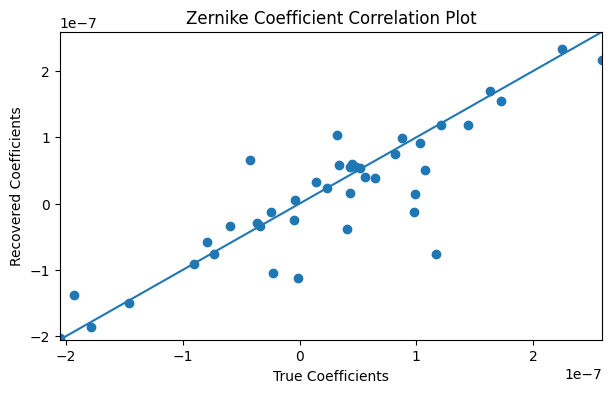

In [54]:
from utils import plot_and_compare
plot_and_compare(data, model.model(), titles=['fake Data', 'Model'], colorbars=True, cbar_label='Counts', stretch='sqrt')

In [44]:
residual = data - model.model()
rel_resid = residual / data**0.5
plt.imshow(rel_resid)
plt.colorbar()
plt.show()

plt.hist(rel_resid.flatten(), bins=50)
# plt.plot(jax.scipy.stats.norm.pdf(np.linspace(rel_resid.min(), rel_resid.max(), 100)))
plt.show()

Array([[ 1.41581191e-08, -2.28516885e-08, -3.39096680e-08,
         5.16728633e-08,  8.21803852e-08, -5.99087926e-08],
       [ 1.16806184e-07,  2.59380300e-07, -3.67120134e-09,
         4.48676580e-08,  1.21307565e-07,  1.62927066e-07],
       [ 1.44757252e-07,  8.77390676e-08,  1.07811346e-07,
        -9.03737742e-08,  4.79827627e-08,  5.60173028e-08],
       [ 4.34954615e-08,  9.78750094e-08,  3.20635429e-08,
        -4.73720840e-09, -3.67869823e-08,  1.03505862e-07],
       [-4.27198472e-08,  4.02864870e-08,  4.29927489e-08,
         6.50133742e-08, -2.05387423e-07, -7.36363859e-08],
       [-1.19046334e-07,  2.25206549e-07,  9.85274369e-08,
        -1.46169484e-07, -1.78247490e-07,  3.37847865e-08],
       [-1.93311521e-07, -7.94441206e-08, -8.87270757e-10,
         1.72872973e-07,  2.33345308e-08, -2.41264573e-08]],      dtype=float32)

In [46]:
plt.imshow(100*(data - model.model())/data)
plt.colorbar()

(200, 7, 6)

NameError: name 'plt' is not defined